In [1]:
from IPython.display import Image
import contexttimer
import time
import math
from numba import jit
import multiprocessing
import threading
from joblib import Parallel
import logging

# Course objectives

* The objective is to learn how to write shared-memory Python programs that make use of multiple cores on
  a single node. The tutorial will introduce several python modules that schedule operations and manage
  data to simplify multiprocessing with Python.

1. Benchmarking parallel code
1. Understanding the global interpreter lock (GIL)
1. Multiprocessing and multithreading with [joblib](https://pythonhosted.org/joblib/)
1. Checkpointing/restarting multiprocessor jobs
1. Multithreaded file i/o with [zarr](http://zarr.readthedocs.io/en/latest/) and [parquet](https://arrow.apache.org/docs/python/parquet.html)
1. Writing extensions that release the GIL:
   1.  Using [numba](http://numba.pydata.org/)
   1.  Using [cython](http://cython.org/)
   1.  Using C++ and [pybind11](http://pybind11.readthedocs.io/en/stable/?badge=stable) with [xtensor-python](https://xtensor-python.readthedocs.io/en/latest/)
1. Using [dask](http://dask.pydata.org/en/latest/)/[xarray](http://xarray.pydata.org/en/stable/dask.html) to analyze out-of-core datasets
1. Visualizing parallelization with dask
1. Setting up a conda-forge environment for parallel computing




## Motivation -- the prince of memory and processors continues to decrease

Commodity data processor:  [8 cores/16 threads with 16 Gbytes of RAM for $US 2000](http://www.titancomputers.com/Titan-X179-Intel-Xeon-E5-V4-Broadwell-EP-Ultra-p/x179.htm)

### How do we get the most from these cores?

### Threads and processes

> From [Wikipedia](https://en.wikipedia.org/wiki/Thread_(computing)):

>> "In computer science, a thread of execution is the smallest sequence of programmed instructions that can be managed independently by a scheduler, which is typically a part of the operating system.[1] The implementation of threads and processes differs between operating systems, but in most cases a thread is a component of a process. Multiple threads can exist within one process, executing concurrently and sharing resources such as memory, while different processes do not share these resources. In particular, the threads of a process share its executable code and the values of its variables at any given time."


#### Threads and processes in Python

[Reference: Thomas Moreau and Olivier Griesel, PyParis 2017 [Mor2017]](https://tommoral.github.io/pyparis17/#1)

#### Python global intepreter lock

1. Motivation: python objects (lists, dicts, sets, etc.) manage their own memory by storing a counter that keeps track of how many copies of an object are in use.  Memory is reclaimed when that counter goes to zero.

1. Having a globally available reference count makes it simple for Python extensions to create, modify and share python objects.

1. To avoid memory corruption, a python process will only allow 1 thread at any given moment to run python code.  Any thread that wants to access python objects in that process needs to acquire the global interpreter lock (GIL).

1. A python extension written in C, C++ or numba is free to release the GIL, provided it doesn't create, destroy or modify any python objects.  For example: numpy, pandas, scipy.ndimage, scipy.integrate.quadrature all release the GIL

1. Many python standard library input/output routines (file reading, networking) also release the GIL

1. On the other hand:  hdf5, and therefore h5py and netCDF4, don't release the GIL and are single threaded.

1. Python comes with many libraries to manage both processes and threads.


### Thread scheduling

If multiple threads are present in a python process, the python intepreter releases the GIL at specified intervals (5 miliseconds default) to allow them to execute:

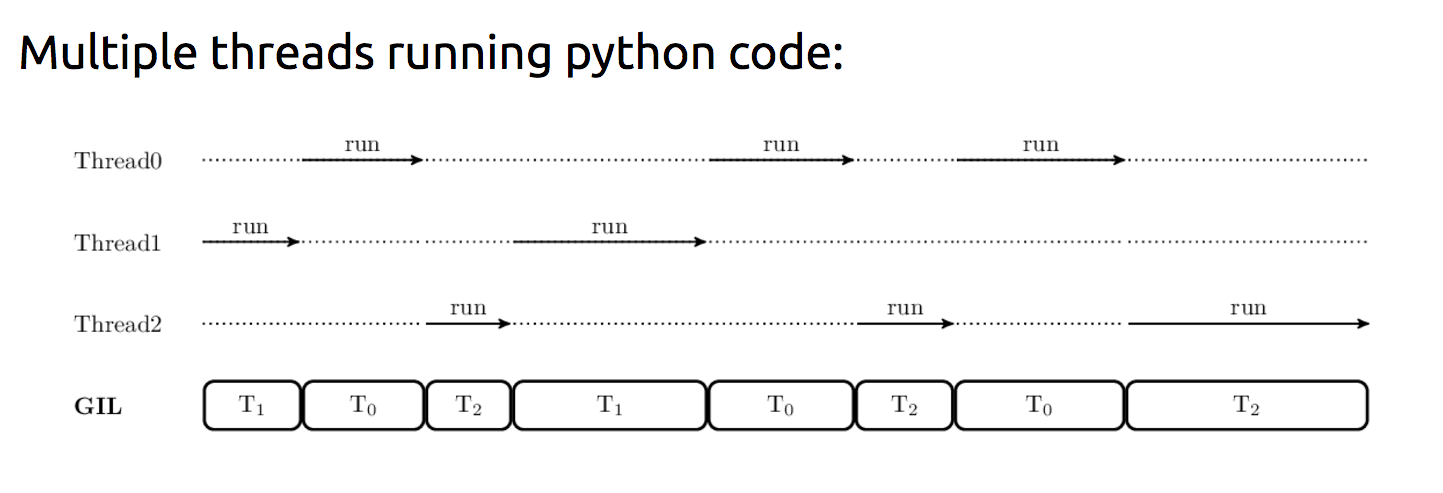

In [2]:
Image(filename='images/morreau1.png')  #[Mor2017]

#### Note that these three threads are taking turns, resulting in a computation that runs slightly slower (because of overhead) than running on a single thread

### Releasing the GIL

If the computation running on the thread has released the GIL, then it can run independently of other threads in the process.  Execution of these threads are scheduled by the operating system along with all the other threads and processes on the system.

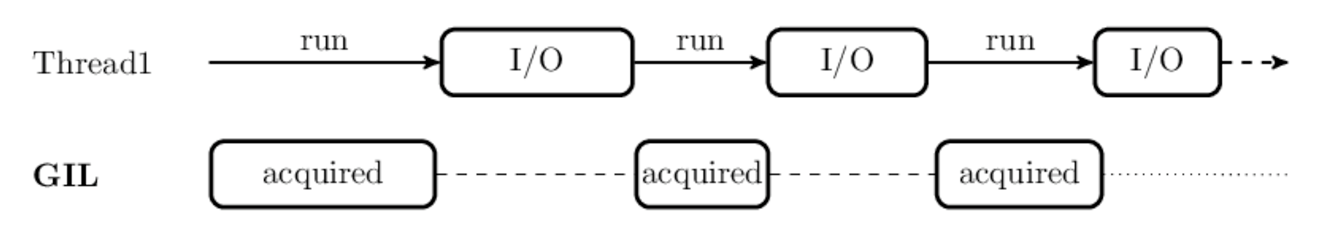

In [3]:
Image(filename='images/morreau2.png')  #[Morr2017]

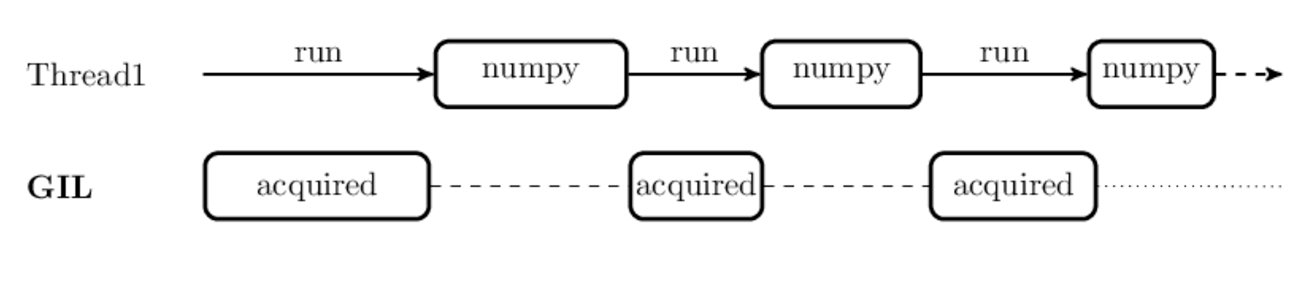

In [4]:
Image(filename='images/morreau3.png') #[Morr2017]

### Timing python code


One easy way to tell whether you are utilizing multiple cores is to track the wall clock time measured by [time.perf_counter](https://docs.python.org/3/library/time.html#time.perf_counter) against the total cpu time used by all threads meausred with [time.process_time](https://docs.python.org/3/library/time.html#time.process_time)

In [5]:
def wait_loop(n):
    """
    Function under test.
    """
    for m in range(n):
        for l in range(m):
            for j in range(l):
                for i in range(j):
                    i=i+4
                    out=math.sqrt(i)
                    out=out**2.
    return out

In [6]:
nloops=200
with contexttimer.Timer(time.perf_counter) as pure_wall:
    with contexttimer.Timer(time.process_time) as pure_cpu:
        result=wait_loop(nloops)
print(f'pure python wall time {pure_wall.elapsed} and cpu time {pure_cpu.elapsed}')

pure python wall time 14.408897751010954 and cpu time 14.25352


In [7]:
@jit('float64(int64)', nopython=True, nogil=True)
def wait_loop_nogil(n):
    """
    Function under test.
    """
    for m in range(n):
        for l in range(m):
            for j in range(l):
                for i in range(j):
                    i=i+4
                    out=math.sqrt(i)
                    out=out**2.
    return out

In [8]:
@jit('float64(int64)', nopython=True, nogil=False)
def wait_loop_withgil(n):
    """
    Function under test.
    """
    for m in range(n):
        for l in range(m):
            for j in range(l):
                for i in range(j):
                    i=i+4
                    out=math.sqrt(i)
                    out=out**2.
    return out

In [9]:
with contexttimer.Timer(time.perf_counter) as numba_wall:
    with contexttimer.Timer(time.process_time) as numba_cpu:
        result=wait_loop_withgil(nloops)
print(f'numba wall time {numba_wall.elapsed} and cpu time {numba_cpu.elapsed}')
print(f"numba speed-up factor {(pure_wall.elapsed - numba_wall.elapsed)/numba_wall.elapsed}")

numba wall time 0.006623808993026614 and cpu time 0.003891999999996898
numba speed-up factor 2174.319029606725


In [40]:
logging.basicConfig(level=logging.DEBUG,
                    format='%(message)s %(threadName)s %(processName)s',
                    )

def find_ids():
    logging.debug('debug logging: ')

In [41]:
import copy
nprocs=3
nloops=1250
thread_ids=[(find_ids,[],{}) for i in range(nprocs)]
thread2=copy.deepcopy(thread_ids)
jobs=[(wait_loop_nogil,[nloops],{}) for i in range(nprocs)]
print(jobs)

[(CPUDispatcher(<function wait_loop_nogil at 0x111708e18>), [1250], {}), (CPUDispatcher(<function wait_loop_nogil at 0x111708e18>), [1250], {}), (CPUDispatcher(<function wait_loop_nogil at 0x111708e18>), [1250], {})]


In [44]:
with contexttimer.Timer(time.perf_counter) as wall:
    with contexttimer.Timer(time.process_time) as cpu:
        with Parallel(n_jobs=nprocs,backend='threading') as parallel:
            parallel(thread_ids)
            results=parallel(jobs)
            parallel(thread_ids)
            results=parallel(jobs)
            parallel(thread_ids)
        print(results)
print(f'wall time {wall.elapsed} and cpu time {cpu.elapsed}')

debug logging:  Thread-74 ) MainProcess
debug logging:  Thread-75 ) MainProcess
debug logging:  Thread-76 ) MainProcess
debug logging:  Thread-76 ) MainProcess
debug logging:  Thread-75 ) MainProcess
debug logging:  Thread-74 ) MainProcess
debug logging:  Thread-75 ) MainProcess
debug logging:  Thread-76 ) MainProcess
debug logging:  Thread-74 ) MainProcess


[1250.0, 1250.0, 1250.0]
wall time 2.4667026540264487 and cpu time 6.626355000000004


In [45]:
from cffi import FFI
ffi=FFI()
ffi.cdef("""
    void get_thread_id(char *thread_id);
    void get_process_id(char *process_id);
""")
lib = ffi.dlopen('/usr/local/lib/libthread_tools.so')
print(dir(lib))
arg_thread = ffi.new("char[]",25) 
lib.get_thread_id(arg_thread)
out_thread=ffi.string(arg_thread)
str_out=out_thread.decode('utf-8')
print(f"-{str_out}-")
arg_process = ffi.new("char[]",25) 
lib.get_process_id(arg_process)
out_process=ffi.string(arg_process)
str_out=out_process.decode('utf-8')
print(f"-{str_out}-")

['get_process_id', 'get_thread_id']
-4fdf76a5-
-86931-


In [82]:
nprocs=10
arg_list=[]
fun_list=[]
dict_list=[]
for i in range(nprocs):
    fun_list.append(lib.get_thread_id)
    arg_list.append(ffi.new("char[]",25))
    dict_list.append({})
ptr_list=[[ffi.cast("char*",item)] for item in arg_list]
jobs=list(zip(fun_list,ptr_list,dict_list))
print(jobs)
with Parallel(n_jobs=nprocs,backend='threading') as parallel:
    parallel(jobs)
for item in ptr_list:
    out_thread=ffi.string(item[0]).decode('utf-8')
    print(out_thread)

[(<cdata 'void(*)(char *)' 0x111cffd20>, [<cdata 'char *' 0x7fd308456820>], {}), (<cdata 'void(*)(char *)' 0x111cffd20>, [<cdata 'char *' 0x7fd308444170>], {}), (<cdata 'void(*)(char *)' 0x111cffd20>, [<cdata 'char *' 0x7fd308408160>], {}), (<cdata 'void(*)(char *)' 0x111cffd20>, [<cdata 'char *' 0x7fd30845de50>], {}), (<cdata 'void(*)(char *)' 0x111cffd20>, [<cdata 'char *' 0x7fd308400ad0>], {}), (<cdata 'void(*)(char *)' 0x111cffd20>, [<cdata 'char *' 0x7fd3084090b0>], {}), (<cdata 'void(*)(char *)' 0x111cffd20>, [<cdata 'char *' 0x7fd30840d4d0>], {}), (<cdata 'void(*)(char *)' 0x111cffd20>, [<cdata 'char *' 0x7fd30844f080>], {}), (<cdata 'void(*)(char *)' 0x111cffd20>, [<cdata 'char *' 0x7fd308408750>], {}), (<cdata 'void(*)(char *)' 0x111cffd20>, [<cdata 'char *' 0x7fd308400e80>], {})]
33283f1e
db719b9a
56122d26
47a37757
ab33a16d
57ece20a
385f4e24
d98404d5
7b77f4a7
8a7f0d2c


In [ ]:
@jit('float64(int64)', nopython=True, nogil=True)
def wait_loop_nogil(n):
    """
    Function under test.
    """
    for m in range(n):
        for l in range(m):
            for j in range(l):
                for i in range(j):
                    i=i+4
                    out=math.sqrt(i)
                    out=out**2.
    return out